# **MULTIPLE MODELS FOR PREDICTING SENTIMENT**

+ Doing sentiment analysis using different kinds of layers to see how they affect the model.
+ We will be using glue/sst2 dataset, which is available through tensorflow_datasets.
+ The General Language Understanding Evaluation (GLUE) benchmark is a collection of resources for training, evaluating, and analyzing natural language understanding systems.
+ These resources include the Stanford Sentiment Treebank (SST) dataset that consists of sentences from movie reviews and human annotations of their sentiment.
+ This colab uses version 2 of the SST dataset.

The splits are:

+ train 67,349
+ validation 872

and the column headings are:

+ sentence
+ label

IMPORT LIBRARIES

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

GET THE DATASET

In [2]:
# Get the dataset.
# It has 70000 items, so might take a while to download
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteCWKNU9/glue-train.tfrecord*...:   0%|          |…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteCWKNU9/glue-validation.tfrecord*...:   0%|      …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteCWKNU9/glue-test.tfrecord*...:   0%|          | …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})
2
['negative', 'positive']


In [4]:
dataset.keys()

dict_keys([Split('train'), Split('validation'), Split('test')])

In [11]:
# Get the training and validation datasets
dataset_train, dataset_validation = dataset['train'], dataset['validation']
print(dataset_train)
print(dataset_validation)

<PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>
<PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>


In [9]:
# Print some of the entries
for example in dataset_train.take(10):  
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'company once again dazzle and delight us ', shape=(), dtype=string)
Label: 1 

Review: tf.Tensor(b"'s no surprise that as a director washington demands and receives excellent performances , from himself and from newcomer derek luke ", shape=(), dtype=string)
Label: 1 

Review: tf.Tensor(b', this cross-cultural soap opera is painfully formulaic and stilted . ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b", the film is n't nearly as downbeat as it sounds , but strikes a tone that 's alternately melancholic , hopeful and strangely funny . ", shape=(), dtype=string)
Label: 1 

Review: tf.Tensor(b'only masochistic moviegoers need apply . ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'convince alm

In [14]:
# Get the sentences and the labels
# for both the training and the validation sets
training_reviews = []
training_labels = []
 
validation_reviews = []
validation_labels = []

# The dataset has 67,000 training entries, but that's a lot to process here!

# If you want to take the entire dataset: WARNING: takes longer!!
# for item in dataset_train.take(-1):

# Take 10,000 reviews
for item in dataset_train.take(10000):
  review, label = item["sentence"], item["label"]
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_reviews))

# print some of the reviews and labels
for i in range(0, 2):
  print (training_reviews[i])
  print (training_labels[i])

# Get the validation data
# there's only about 800 items, so take them all
for item in dataset_validation.take(-1):  
  review, label = item["sentence"], item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_reviews[i])
  print (validation_labels[i])



Number of training reviews is:  10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


TOKENIZE THE WORDS AND SEQUENCE THE SENTENCES

In [15]:
# There's a total of 21224 words in the reviews
# but many of them are irrelevant like with, it, of, on.
# If we take a subset of the training data, then the vocab
# will be smaller.

# A reasonable review might have about 50 words or so,
# so we can set max_length to 50 (but feel free to change it as you like)

vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, "'": 2, 'the': 3, 'and': 4, 'a': 5, 'of': 6, 'b': 7, 'to': 8, "'s": 9, 'in': 10, 'that': 11, 'is': 12, 'it': 13, 'as': 14, "b'a": 15, 'with': 16, 'film': 17, 'movie': 18, 'for': 19, "b'the": 20, 'its': 21, 'an': 22, 'you': 23, 'this': 24, 'but': 25, 'on': 26, 'be': 27, "n't": 28, "b'is": 29, 'by': 30, "b'": 31, 'at': 32, 'not': 33, 'or': 34, 'about': 35, 'more': 36, 'one': 37, 'so': 38, 'than': 39, 'all': 40, 'out': 41, 'from': 42, 'his': 43, 'like': 44, 'have': 45, 'are': 46, 'good': 47, 'story': 48, 'up': 49, 'who': 50, 'most': 51, 'has': 52, 'too': 53, 'into': 54, 'your': 55, 'time': 56, 'characters': 57, 'just': 58, 'comedy': 59, 'their': 60, 'funny': 61, 'life': 62, 'i': 63, 'even': 64, 'well': 65, "b'of": 66, 'little': 67, 'much': 68, 'does': 69, 'if': 70, 'will': 71, 'very': 72, 'what': 73, "b'an": 74, 'can': 75, 'which': 76, 'been': 77, 'no': 78, 'love': 79, "b'that": 80, "''": 81, 'bad': 82, "b'to": 83, 'best': 84, 'work': 85, 'action': 86, 'humor': 87, 'way': 88,

PAD SEQUENCES

In [16]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

MODEL USING EMBEDDING

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            64000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


TRAIN THE MODEL

In [18]:
num_epochs = 50
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/50
313/313 [==============================] - 2s 2ms/step - loss: 0.6829 - accuracy: 0.5582 - val_loss: 0.6877 - val_accuracy: 0.5183
Epoch 2/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6704 - accuracy: 0.5784 - val_loss: 0.6701 - val_accuracy: 0.6021
Epoch 3/50
313/313 [==============================] - 1s 2ms/step - loss: 0.6497 - accuracy: 0.6259 - val_loss: 0.6450 - val_accuracy: 0.6399
Epoch 4/50
313/313 [==============================] - 1s 3ms/step - loss: 0.6210 - accuracy: 0.6744 - val_loss: 0.6128 - val_accuracy: 0.6881
Epoch 5/50
313/313 [==============================] - 1s 3ms/step - loss: 0.5876 - accuracy: 0.7093 - val_loss: 0.5827 - val_accuracy: 0.7271
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 0.5538 - accuracy: 0.7420 - val_loss: 0.5556 - val_accuracy: 0.7454
Epoch 7/50
313/313 [==============================] - 1s 2ms/step - loss: 0.5220 - accuracy: 0.7751 - val_loss: 0.5322 - val_accuracy: 0.7477
Epoch 

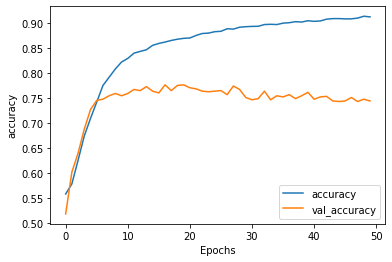

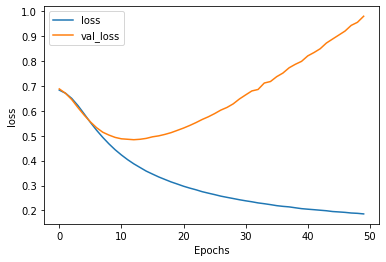

In [19]:
## plot the accuracy and loss
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

FUNCTION TO PREDICT THE SENTIMENTS OF REVIEWS

In [20]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]

In [21]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews           

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)

1/1 [==============================] - 0s 71ms/step
I loved this movie
[0.5815122]


that was the worst movie I've ever seen
[0.10329077]


too much violence even for a Bond film
[0.00013011]


a captivating recounting of a cherished myth
[0.9255985]




DEFINE A FUNCTION TO TRAIN AND SHOW THE RESULTS OF MODELS WITH DIFFERENT LAYERS

In [22]:
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

CNN MODEL

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            64000     
                                                                 
 conv1d (Conv1D)             (None, 46, 16)            1296      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
313/313 [==============================] - 3s 5ms/step - loss: 0.6882 - accuracy: 0.5587 - val_loss: 0.69

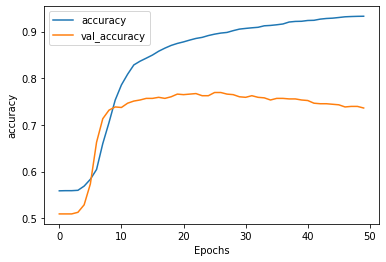

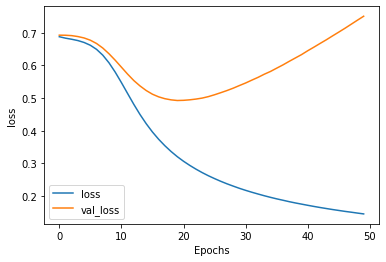

1/1 [==============================] - 0s 64ms/step
I loved this movie
[0.9125799]


that was the worst movie I've ever seen
[0.00272855]


too much violence even for a Bond film
[0.00018266]


a captivating recounting of a cherished myth
[0.8011954]




In [23]:
num_epochs = 50

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

GRU MODEL

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 15s 36ms/step - loss: 0.6888 - accuracy: 0.5590 - val_loss: 0.6935 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 12s 38ms/step - loss: 0.6861 - accuracy: 0.5590 - 

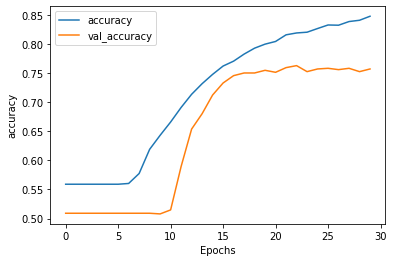

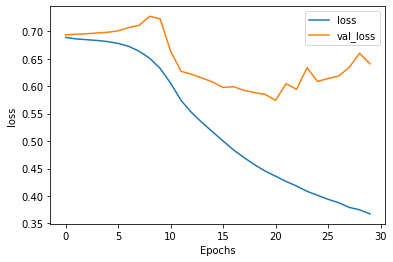

1/1 [==============================] - 1s 705ms/step
I loved this movie
[0.4359514]


that was the worst movie I've ever seen
[0.20111275]


too much violence even for a Bond film
[0.17502782]


a captivating recounting of a cherished myth
[0.4571528]




In [24]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

BIDIRECTIONAL LSTM MODEL

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 15s 34ms/step - loss: 0.6912 - accuracy: 0.5492 - val_loss: 0.6937 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 10s 30ms/step - loss: 0.6879 - accuracy: 0.5590 - 

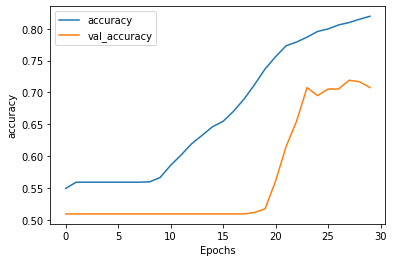

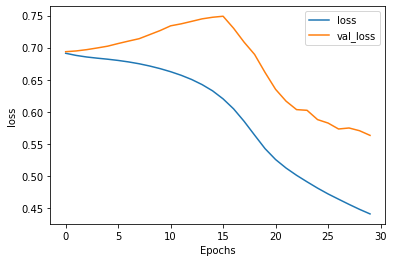

1/1 [==============================] - 1s 659ms/step
I loved this movie
[0.5543581]


that was the worst movie I've ever seen
[0.3185424]


too much violence even for a Bond film
[0.48059312]


a captivating recounting of a cherished myth
[0.61671275]




In [25]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

MULTIPLE BIDIRECTIONAL LSTM LAYERS

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================

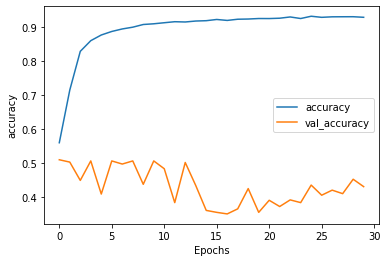

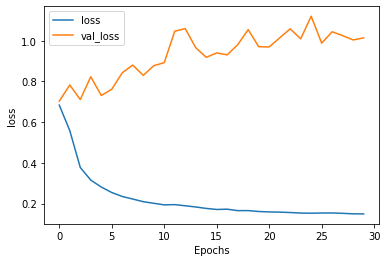

1/1 [==============================] - 1s 1s/step
I loved this movie
[0.5451244]


that was the worst movie I've ever seen
[0.25181597]


too much violence even for a Bond film
[0.01216973]


a captivating recounting of a cherished myth
[0.9958894]




In [26]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

In [27]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7, 
               review8, review9, review10]


In [28]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
1/1 [==============================] - 0s 25ms/step
I loved this movie
[0.5815122]


that was the worst movie I've ever seen
[0.10329077]


too much violence even for a Bond film
[0.00013011]


a captivating recounting of a cherished myth
[0.9255985]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.7028705]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9724874]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.83970475]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.5577104]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed 

In [29]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
1/1 [==============================] - 0s 19ms/step
I loved this movie
[0.9125799]


that was the worst movie I've ever seen
[0.00272855]


too much violence even for a Bond film
[0.00018266]


a captivating recounting of a cherished myth
[0.8011954]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.7400687]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99846816]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.99691164]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9218235]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the 

In [30]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
1/1 [==============================] - 0s 22ms/step
I loved this movie
[0.4359514]


that was the worst movie I've ever seen
[0.20111275]


too much violence even for a Bond film
[0.17502782]


a captivating recounting of a cherished myth
[0.4571528]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.08842538]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.15938811]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.08893234]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.3750745]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disap

In [31]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
1/1 [==============================] - 0s 27ms/step
I loved this movie
[0.5543581]


that was the worst movie I've ever seen
[0.3185424]


too much violence even for a Bond film
[0.48059312]


a captivating recounting of a cherished myth
[0.61671275]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.24745473]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.44544014]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.21924646]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.35662028]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I wa

In [32]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
1/1 [==============================] - 0s 29ms/step
I loved this movie
[0.5451244]


that was the worst movie I've ever seen
[0.25181597]


too much violence even for a Bond film
[0.01216974]


a captivating recounting of a cherished myth
[0.9958894]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.10929272]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99621385]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.99454945]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9937759]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was

****